In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.8 MB/s eta 0:00:00


In [ ]:
pip install sacremoses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895241 sha256=15a01291c0adb9c0fe14de803a3692381b19fe9558df706483a1353196be04eb
  Stored in directory: /root/.cache/pip/wheels/00/24/97/a2ea5324f36bc626e1ea0267f33db6aa80d157ee977e9e42fb
Successfully built sacremoses


In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import torch
from transformers import HerbertTokenizer, RobertaModel, AutoTokenizer, BertModel

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
tokenizer = HerbertTokenizer.from_pretrained("allegro/herbert-large-cased")
model = RobertaModel.from_pretrained("allegro/herbert-large-cased")

You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at allegro/herbert-large-cased were not used when initializing RobertaModel: ['bert.encoder.layer.15.attention.self.key.weight', 'bert.encoder.layer.4.attention.self.value.weight', 'bert.encoder.layer.21.attention.output.LayerNorm.bias', 'bert.encoder.layer.20.intermediate.dense.bias', 'bert.embeddings.token_type_embeddings.weight', 'bert.encoder.layer.3.intermediate.dense.bias', 'bert.encoder.layer.16.attention.output.LayerNorm.bias', 'bert.encoder.layer.17.attention.self.query.bias', 'bert.encoder.layer.9.attention.self.query.weight', 'bert.encoder.layer.13.attention.self.query.bias', 'bert.encoder.layer.3.output.dense.weight', 'bert.encoder.layer.20.attention.self.value.bias', 'bert.encoder.layer.20.attention.output.dense.bias', 'bert.encoder.layer.12.intermediate.dense.weight', 'bert.encoder.layer.8.output.dense.bias', 'bert.encoder.layer.14.attention.self.value.weight', 'bert.encoder.layer.19.attention.self.query.bias', 'bert.encoder.layer.6.in

In [ ]:
def draw_learning_curve(history, key='accuracy'):

  fig, ax = plt.subplots(1, 2, figsize=(12,6))
  ax[0].plot(history.history[key])
  ax[0].plot(history.history['val_'+ key] )
  ax[0].set_ylabel(key.title())
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['train', 'val'])

  ax[1].plot(history.history['loss'])
  ax[1].plot(history.history['val_loss'] )
 # ax[1].set_ylim([0,1])
  ax[1].set_ylabel('loss'.title())
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['train', 'val'])
  fig.suptitle('Learning curve')
  plt.show()

In [ ]:
def get_model():

  models = [
      ["decision_tree", DecisionTreeClassifier(max_depth=20)],
      ["random_forest", RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)],
      ["xgboost", xgb.XGBClassifier(n_estimators=100, random_state=0)],
      ["lgbm", lgb.LGBMClassifier(n_estimators=50, random_state=0, max_depth=10)]
  ]
  return models

In [ ]:
def run_models(X_train, y_train, X_test, y_test, df, data_type):

  for model_name, model_clf in get_model:

    scores = model_clf.fit(X_train, y_train)
    y_pred = model_clf.predict(X_test)
    num_classes = len(df['Label'].unique())
    score = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_clf.classes_)
    disp.plot()
    disp.ax_.set_title("Model: {} | Data type: {} | Classes: {} | Acc: {}".format(model_name, data_type, num_classes, score))
    plt.savefig('/content/figs/{}_{}_{}_classes.png'.format(model_name, data_type, num_classes))
    files.download('{}_{}_{}_classes.png'.format(model_name, data_type, num_classes))

  return score


In [ ]:
df_raw = pd.read_csv('/content/wiersze_do_BERT_light.csv', ";")
df_raw .columns

<ipython-input-20-68c6b8c59a3f>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df_raw = pd.read_csv('/content/wiersze_do_BERT_light.csv', ";")


Index(['Author', 'Title', 'Text', 'From', 'Note', 'Words', 'Label', 'Gender',
       'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'],
      dtype='object')

In [ ]:
df_raw  = df_raw .drop(columns = ['Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'])
df_raw.shape

(400, 8)

In [ ]:
df_women = df_raw[200:]
df_men = df_raw[:200]
df_women = df_women.sample(frac = 1).reset_index(drop=True)
df_men = df_men.sample(frac = 1).reset_index(drop=True)

In [ ]:
def get_data_set(labels, df):
  idxs = []
  for label in labels:
    idxs_for_label, = np.where(df['Label'] == label)
    for idx in idxs_for_label:
      idxs.append(idx)

  new_df = df.iloc[idxs]
  new_df = new_df.sample(frac = 1).reset_index(drop=True)
  return new_df

In [ ]:
labels = [0,1,2,3,4,5,6,7]
df_light = get_data_set(labels, df_raw)
print("Number of classes: {}".format(len(df_light['Label'].unique())))
print("Shape of new data set: {}".format(df_light.shape))

Number of classes: 8
Shape of new data set: (400, 8)


In [ ]:
herbert = ["Herbert", HerbertTokenizer.from_pretrained("allegro/herbert-large-cased"), RobertaModel.from_pretrained("allegro/herbert-large-cased")]
bert = ["Bert", AutoTokenizer.from_pretrained("bert-base-uncased"), BertModel.from_pretrained("bert-base-uncased")]


You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at allegro/herbert-large-cased were not used when initializing RobertaModel: ['bert.encoder.layer.9.intermediate.dense.bias', 'bert.encoder.layer.21.attention.self.value.bias', 'bert.encoder.layer.15.attention.self.key.bias', 'bert.encoder.layer.14.attention.self.key.weight', 'bert.encoder.layer.13.intermediate.dense.bias', 'bert.encoder.layer.6.attention.self.key.weight', 'bert.encoder.layer.11.attention.self.query.bias', 'bert.encoder.layer.12.attention.self.query.bias', 'bert.encoder.layer.16.output.dense.weight', 'bert.encoder.layer.7.output.LayerNorm.weight', 'bert.encoder.layer.11.attention.self.value.bias', 'bert.encoder.layer.5.attention.self.query.weight', 'bert.encoder.layer.9.intermediate.dense.weight', 'bert.encoder.layer.18.attention.self.value.weight', 'bert.encoder.layer.16.output.Laye

In [ ]:
from transformers import AutoTokenizer, BertModel

In [ ]:
def make_embedding(df, model):

  X_stack = []

  model_name, tokenizer, model = model
  embedded = {}
  num_idxs = df.shape[0]
  for idx in tqdm(range(0,num_idxs)):
    single_poem_input = df['Text'][idx]
    inputs = tokenizer.batch_encode_plus([single_poem_input], max_length = 512, padding="longest", add_special_tokens=True, return_tensors="pt",)
    single_poem_output = model(**inputs)
    X_single_poem = single_poem_output[0][:,0,:].detach().numpy()
    X_stack.append(X_single_poem[0])

    embedded[idx] = X_single_poem[0], df['Label'][idx]

  df_embedded = pd.DataFrame.from_dict(embedded,  orient='index', columns=['{}_embedding'.format(model_name), 'label'])

  return df_embedded

In [ ]:
df_light = df_women

In [ ]:
embedded = make_embedding(df_light, herbert)

100%|██████████| 200/200 [00:34<00:00,  5.85it/s]


In [ ]:
df_light['Text'][8]

'Jaś z jarmarku przywiózł figę. Józio dwie figi — dla intrygi. Adaś z traw uplótł pierścioneczek, w ciągu dalekich w las wycieczek. Ten przyniósł bukiet z ostromleczów — (bo jest pogodny — lubi żarty —) — tamten — w prezencie — (jakby przeczuł, że się ucieszę): stare karty. — Zepsuty kompas — — nudną powieść — którą mnie czytać nikt nie zmusi, i granat znaleziony w rowie, który wybuchnąć kiedyś musi. W skrzynce cedrowej chowam dary moich kochanków, tych trzech króli… — pierścionek z trawy — — kompas stary, — granat podobny srebrnej kuli… Wreszcie za żonę wziął mnie Zbyszek. (Wmawiano w niego: ty idioto!) A ten — o dziwy, co za zbytek! obrączkę dał mi szczerozłotą. Nie bez wzdychania, wzdychał bowiem, sam jeździł po nią swą Minerwą, — jak się targował! — wreszcie z werwą rzekł: «Drogo, ale nic nie powiem!» (Bo już od wieków i Wierzynków, sarmacka szlachta gardzi złotem, a ceni miedź! i stal uczynków! złoto do złota idź z powrotem.) Na tym się wprawdzie i skończyło z podarunkami już na a

In [ ]:
embedded_bert = make_embedding(df_light, bert)

In [ ]:
embedded

,Herbert_embedding,label
0,"[0.89399993, -0.2852554, 1.2329097, 2.262266, ...",6
1,"[0.6954153, -0.4211708, 1.4730368, 2.2048836, ...",5
2,"[0.6737245, -0.46535006, 1.3316852, 2.223329, ...",4
3,"[0.664843, -0.515572, 1.3359684, 2.055219, 0.1...",4
4,"[0.66640323, -0.54636365, 1.3193268, 2.1869056...",6
...,...,...
195,"[0.62609434, -0.57244605, 1.3011361, 2.117001,...",4
196,"[0.5622949, -0.47818857, 1.1856289, 1.8680024,...",7
197,"[0.6926743, -0.55398434, 1.2953496, 2.1067302,...",7
198,"[0.67652816, -0.62237394, 1.1974002, 2.134405,...",4


In [ ]:
X_stack = []
    num_idxs = df.shape[0]
    for idx in tqdm(range(0,num_idxs)):
      single_poem_input = df['Text'][idx]
      inputs = tokenizer.batch_encode_plus([single_poem_input], padding="longest", add_special_tokens=True, return_tensors="pt",)
      single_poem_output = model(**inputs)
      X_single_poem = single_poem_output[0][:,0,:].detach().numpy()
      X_stack.append(X_single_poem[0])

In [ ]:
X = np.stack(embedded['Herbert_embedding'])
#y = df_light['Label']

#jeśli jest mniej niż 8 klas:
y = df_light['Label'].factorize()[0]
print(X.shape)


(200, 1024)


In [ ]:
X[0]

array([ 0.89399993, -0.2852554 ,  1.2329097 , ...,  0.20117314,
        0.86354864, -0.24321513], dtype=float32)

In [ ]:
X_normalized = np.zeros(X.shape)
for idx in range(0, X.shape[0]):
  x = X[idx,:]
  X_normalized[idx,:] = (x - np.mean(x)) / np.std(x)

Text(0.5, 1.0, 'PCA of Poems dataset')

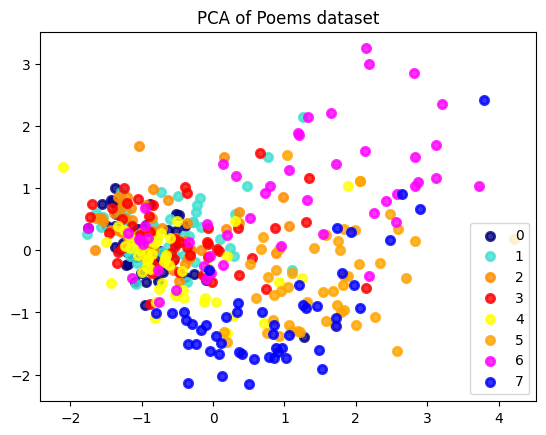

In [ ]:
pca = PCA(n_components=2)
X_r = pca.fit_transform(X)

plt.figure()
#colors = ["0", "1", "2", "3", "4", "5", "6", "7"]
colors = ["navy", "turquoise", "darkorange", 'red', 'yellow', 'orange', 'magenta', 'blue']
lw = 2
target_names = [0, 1, 2, 3, 4, 5, 6, 7]

for color, i, target_name in zip(colors, [0, 1, 2, 3, 4, 5, 6, 7], target_names):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of Poems dataset")

In [ ]:
df_tsne = pd.DataFrame()
df_tsne["y"] = df_light['Autor']

perps = [5, 10, 15, 20, 25, 30, 35, 40]

for perp in perps:

  plt.figure(figsize = (10,10))
  z = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=perp).fit_transform(X, y)

  df_tsne["comp-1{}".format(perp)] = z[:,0]
  df_tsne["comp-2{}".format(perp)] = z[:,1]

  sns.scatterplot(x="comp-1{}".format(perp), y="comp-2{}".format(perp), hue=df_tsne.y.tolist(),
                palette=sns.color_palette("Set2", 4),
                data=df_tsne, s=100).set(title="Poems data t-SNE projection | perplexity: {}".format(perp))



In [ ]:
df_tsne


,y,comp-15,comp-25,comp-110,comp-210,comp-115,comp-215,comp-120,comp-220,comp-125,comp-225,comp-130,comp-230,comp-135,comp-235,comp-140,comp-240
0,7,41.606277,0.290051,27.772623,-8.223926,-10.538333,-9.713636,-8.720895,-6.500459,-6.605505,7.989352,5.114269,-7.095960,-5.995740,4.468844,-3.841214,-1.995270
1,2,-3.470707,-27.208366,-19.949039,3.280273,16.369085,-4.704470,-2.758612,4.513546,7.993317,1.561222,-7.799418,2.446577,1.660388,-6.067751,-0.791563,5.249575
2,3,8.038198,-2.456364,-3.999078,-14.215513,-6.245975,-1.867928,-0.760515,-6.173198,0.153895,4.038137,4.635808,-1.184904,-1.747301,-0.726658,2.127193,-2.596311
3,2,-22.123758,10.799695,-15.066751,6.462897,6.769877,8.037064,9.201137,1.312530,7.553075,-2.254946,-6.467607,4.003677,4.842926,-4.727655,0.470234,5.363458
4,4,-4.767189,15.096381,-3.758413,-4.990580,0.667572,3.496280,-5.897579,-4.018786,-7.541899,0.325408,1.115328,-3.320661,-3.164736,0.984963,0.007205,-4.520576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0,-22.151808,2.667478,-8.135688,15.833131,6.928785,5.024508,4.999339,5.252172,2.994550,-5.624554,-1.882897,3.580200,3.845778,-0.529476,1.184695,2.830484
396,1,-36.649078,7.763465,-16.036087,13.140695,14.516376,6.287373,8.833744,5.853962,7.027433,-4.702816,-4.223432,5.644330,5.393829,-2.776178,2.239283,4.671076
397,4,-4.129408,-16.541330,9.114930,14.608679,8.278451,-9.990342,-3.954268,8.052116,4.839083,1.716102,-6.574735,-0.867964,0.796384,-4.725613,-2.568286,3.206907
398,5,32.123978,-27.351805,25.875366,-19.957558,-22.940170,-5.337823,-15.966838,-13.653769,-12.690042,11.114897,6.310147,-11.660033,-10.948814,-1.907576,-6.587263,-5.458401


In [ ]:
def print_classes(df):
  authors = {}
  num_classes = len(df['Label'].unique())
  for label in range(0, num_classes):
    i, = np.where(y == label)
    authors['{}'.format(df['Autor'][i[0]])] = label

  return authors

In [ ]:
classes = print_classes(df_light)

In [ ]:
classes

{'Krzysztof Kamil Baczyński': 0,
 'Adam Mickiewicz': 1,
 'Jan Kochanowksi': 2,
 'Czesław Miłosz': 3,
 'Wisława Szymborska': 4,
 'Halina Poświatowska': 5,
 'Maria Pawlikowska-Jasnorzewska': 6,
 'Ewa Lipska': 7}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model_clf = DecisionTreeClassifier(max_depth=20)
%time scores = model_clf.fit(X_train, y_train)

CPU times: user 75.8 ms, sys: 3 µs, total: 75.8 ms
Wall time: 75.4 ms


Text(0.5, 1.0, 'Model: decision_tree | Classes: 4 | Acc: 0.65')

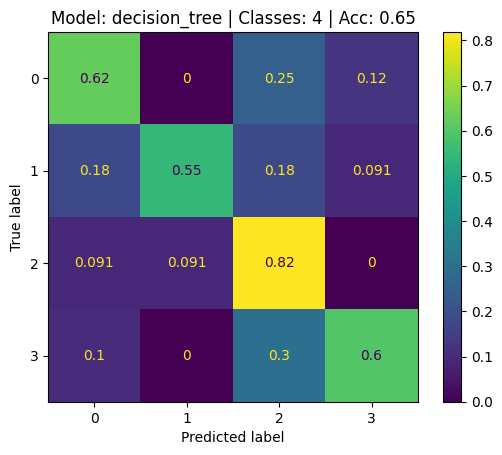

In [ ]:
model_name = "decision_tree"
y_pred = model_clf.predict(X_test)
num_classes = len(df_light['Label'].unique())
score = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_clf.classes_)
disp.plot()
disp.ax_.set_title("Model: {} | Classes: {} | Acc: {}".format(model_name, num_classes, score))
#plt.savefig('/content/figs/{}_{}_classes_vol2.png'.format(model_name, num_classes))

In [ ]:
model_clf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
%time scores = model_clf.fit(X_train, y_train)

CPU times: user 304 ms, sys: 0 ns, total: 304 ms
Wall time: 302 ms


Text(0.5, 1.0, 'Model: random_forest | Classes: 8 | Acc: 0.575')

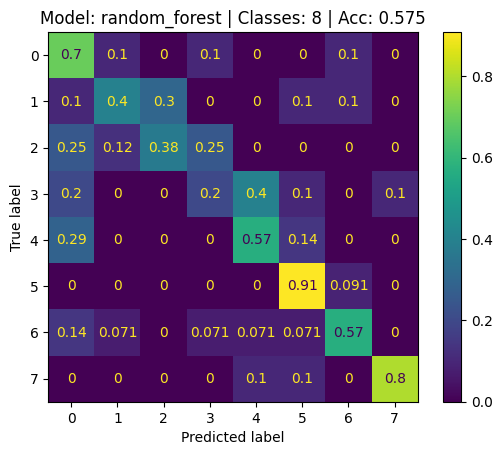

In [ ]:
model_name = 'random_forest'
y_pred = model_clf.predict(X_test)
num_classes = len(df_light['Label'].unique())
score = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_clf.classes_)
disp.plot()
disp.ax_.set_title("Model: {} | Classes: {} | Acc: {}".format(model_name, num_classes, score))
#plt.savefig('/content/figs/{}_{}_classes_vol2.png'.format(model_name, num_classes))

In [ ]:
model_clf = xgb.XGBClassifier(n_estimators=100, random_state=0)
%time scores = model_clf.fit(X_train, y_train)

CPU times: user 17.8 s, sys: 25 ms, total: 17.9 s
Wall time: 910 ms


Text(0.5, 1.0, 'Model: xgboost | Classes: 8 | Acc: 0.6375')

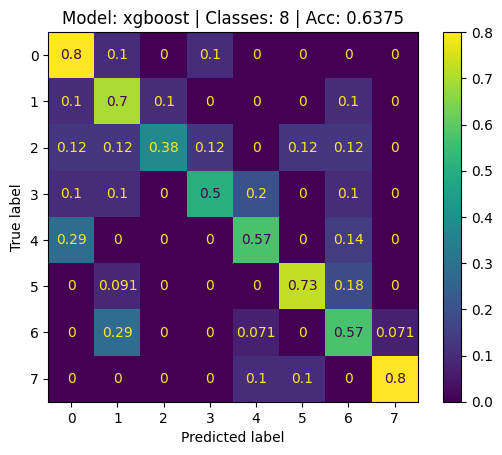

In [ ]:
model_name = 'xgboost'
y_pred = model_clf.predict(X_test)
num_classes = len(df_light['Label'].unique())
score = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_clf.classes_)
disp.plot()
disp.ax_.set_title("Model: {} | Classes: {} | Acc: {}".format(model_name, num_classes, score))
#plt.savefig('/content/figs/{}_{}_classes_vol2.png'.format(model_name, num_classes))

In [ ]:
model_clf = lgb.LGBMClassifier(n_estimators=50, random_state=0, max_depth=10)
%time scores = model_clf.fit(X_train, y_train)

CPU times: user 18.9 s, sys: 31.3 ms, total: 19 s
Wall time: 987 ms


Text(0.5, 1.0, 'Model: lgbm | Classes: 8 | Acc: 0.65')

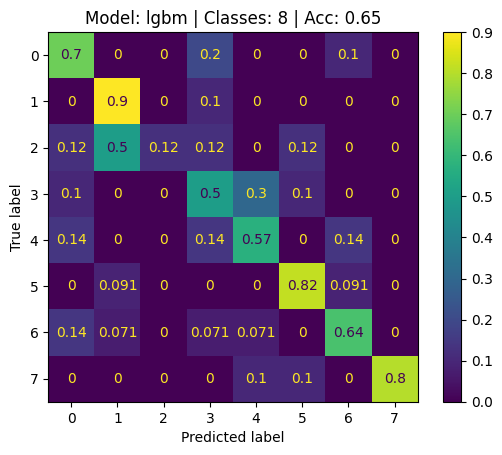

In [ ]:
model_name = 'lgbm'
y_pred = model_clf.predict(X_test)
num_classes = len(df_light['Label'].unique())
score = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_clf.classes_)
disp.plot()
disp.ax_.set_title("Model: {} | Classes: {} | Acc: {}".format(model_name, num_classes, score))
#plt.savefig('/content/figs/{}_{}_classes_vol2.png'.format(model_name, num_classes))

In [ ]:
def get_confusion_matrix(model, X_test, y_test):

  y_pred = model.predict(X_test)

  pred_labels=[]
  for idx in range(len(y_pred)):
    pred_label = np.argmax(y_pred[idx])
    pred_labels.append(pred_label)

  true_labels = y_test
  score = accuracy_score(true_labels, pred_labels)

  ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels, normalize='true')

  return score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
X_train_normalized, X_test_normalized, y_train_normalized, y_test_normalized = train_test_split(X_normalized, y, test_size=0.2, random_state=42)
X_train_normalized, X_val_normalized, y_train_normalized, y_val_normalized = train_test_split(X_train_normalized, y_train_normalized, test_size=0.2, random_state=42)

In [ ]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [ ]:
y_train_normalized = to_categorical(y_train_normalized)
y_val_normalized = to_categorical(y_val_normalized)

In [ ]:
input_size = 1024
num_classes = len(df_light['Label'].unique())
batch_size = 512
epochs = 200

model_NN = Sequential([
    Dense(input_size, input_dim=input_size, activation='relu'),
    Dense(2*input_size, activation='relu'),
   # Dropout(0.1),
   # Dense(2*input_size, activation='relu'),
    #Dropout(0.1),
   # Dense(2*input_size, activation='relu'),
    # Dense(2*input_size, activation='relu'),
    # Dropout(0.2),
    # Dense(2*input_size, activation='relu'),
    # Dense(2*input_size, activation='relu'),
   #  Dropout(0.2),
   #  Dense(4*input_size, activation='relu'),
     Dense(4*input_size, activation='relu'),
    # Dropout(0.3),
    Dense(num_classes, activation='softmax')
  ])

model_NN.compile(loss='categorical_crossentropy', optimizer='Adam', metrics='accuracy')
#callback = keras.callbacks.EarlyStopping(monitor='loss', patience=25)
history = model_NN.fit(X_train, y_train,
          batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(X_val, y_val))



In [ ]:
history_normalized = model_NN.fit(X_train_normalized, y_train_normalized,
          batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(X_val_normalized, y_val_normalized))

3/3 [==============================] - 0s 6ms/step
0.6125


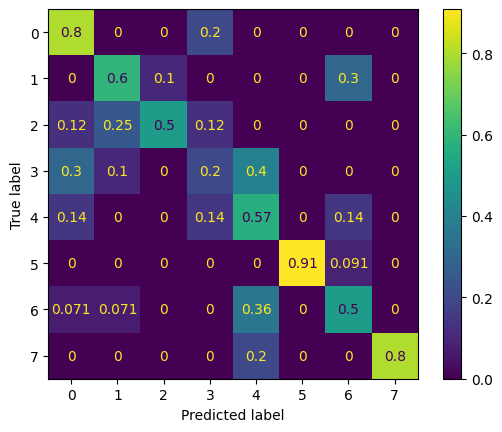

In [ ]:
score = get_confusion_matrix(model_NN, X_test, y_test)
print(score)

3/3 [==============================] - 0s 6ms/step
0.575


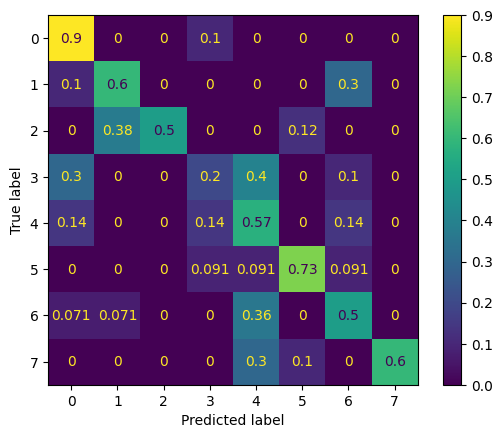

In [ ]:
score = get_confusion_matrix(model_NN, X_test_normalized, y_test_normalized)
print(score)

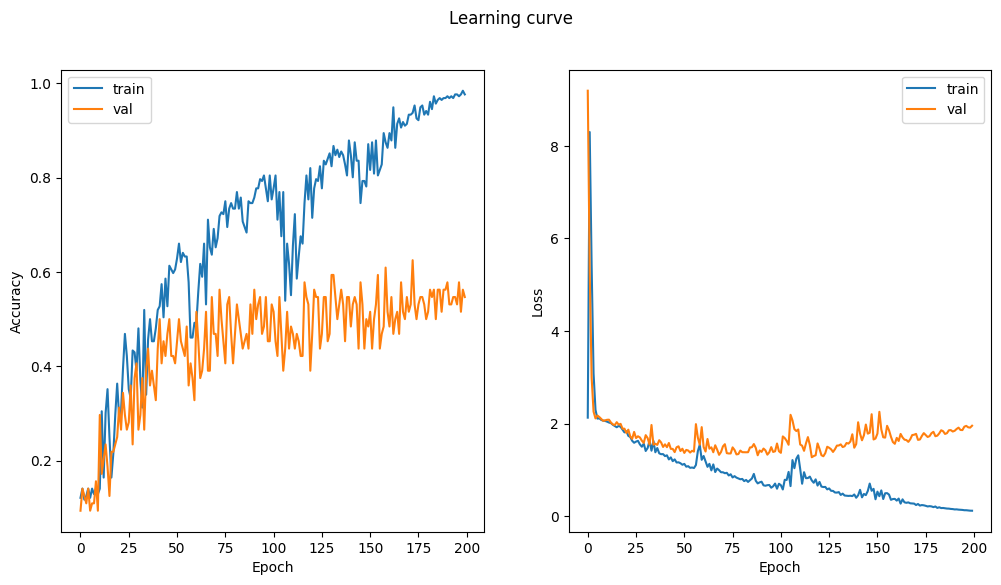

In [ ]:
draw_learning_curve(history, key='accuracy')

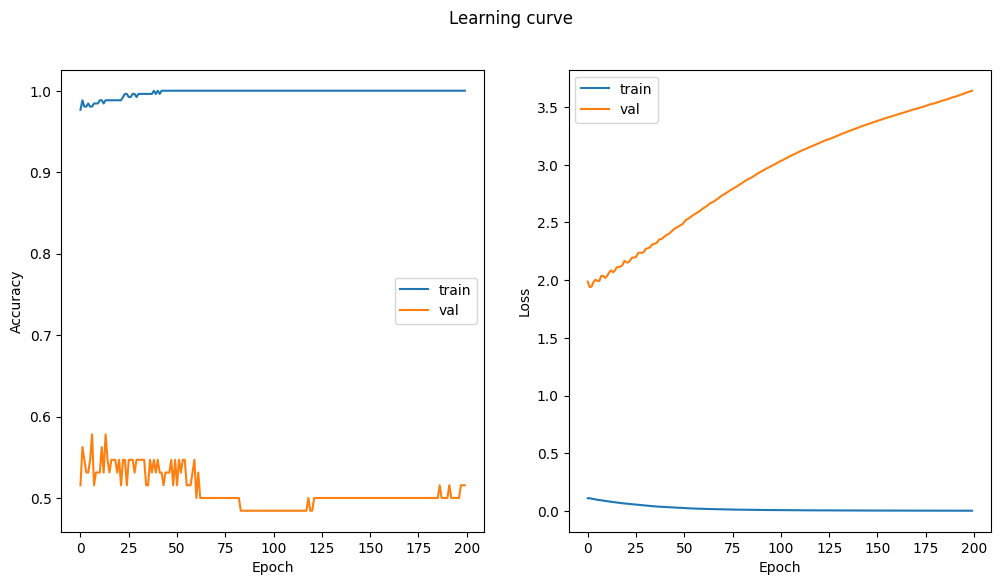

In [ ]:
draw_learning_curve(history_normalized, key='accuracy')

In [ ]:
model_name = 'neural_network'
y_pred = model_NN.predict(X_test)
num_classes = len(y_test.unique())
score = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_clf.classes_)
disp.plot()
disp.ax_.set_title("Model: {} | Classes: {} | Acc: {}".format(model_name, num_classes, score))
plt.savefig('/content/figs/{}_{}_classes.png'.format(model_name, num_classes))

In [ ]:
tokenize = lambda sent: tokenizer.encode_plus(sent, max_length=512, padding='max_length', truncation=True)
df['tokens'] = df['Tekst'].map(tokenize)
df['input_ids'] = df['tokens'].map(lambda t: t['input_ids'] )
df['token_type_ids'] = df['tokens'].map(lambda t: t['token_type_ids'] )
df['attention_mask'] = df['tokens'].map(lambda t: t['attention_mask'] )

In [ ]:
df['input_ids'] = df['tokens'].map(lambda t: t['input_ids'] )
df['token_type_ids'] = df['tokens'].map(lambda t: t['token_type_ids'] )
df['attention_mask'] = df['tokens'].map(lambda t: t['attention_mask'] )

df.sample(3)

In [ ]:
input_ids = np.stack(df['input_ids'])
token_type_ids = np.stack(df['token_type_ids'])
attention_mask = np.stack(df['attention_mask'])

input_ids.shape, token_type_ids.shape, attention_mask.shape

In [ ]:
model = model.to('cuda:0')
inputs = tokenizer.batch_encode_plus(list(df['Tekst'].head(50).values), padding="longest", add_special_tokens=True, return_tensors="pt",).to('cuda:0')
outputs   = model(**inputs)

In [ ]:
inputs = tokenizer.batch_encode_plus(list(df['Tekst'].head(50).values), padding="longest", add_special_tokens=True, return_tensors="pt",)
outputs   = model(**inputs)

In [ ]:
output = model(
    **tokenizer.batch_encode_plus(
        list(df['Tekst'].head(5).values),
        padding="longest",
        add_special_tokens=True,
        return_tensors="pt",
    )
)

In [ ]:
X = output[0][:,0,:].detach().numpy()
y = df['Autor'][:100].factorize()[0]